In [6]:
# import numpy as np
# import pymc as pm
# from pytensor.tensor import TensorVariable

# def logp(value: TensorVariable, mu: TensorVariable) -> TensorVariable:
#     return -(value - mu)**2

# with pm.Model():
#     mu = pm.Normal('mu',0,1)
#     pm.CustomDist(
#         'custom_dist',
#         mu,
#         logp=logp,
#         observed=np.random.randn(100),
#     )
#     idata = pm.sample(100)

In [7]:
import pymc as pm
import numpy as np

with pm.Model() as model:
    mu = pm.Normal('mu',0,1)
    pm.Normal('obs', mu, 1, observed=np.random.randn(100))

In [8]:
import statsmodels as sm

In [3]:
# generate arma(2,2) data 
import numpy as np
import statsmodels.api as sm

arparams = np.array([0, 0])
maparams = np.array([.3, .1])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag

y = sm.tsa.arma_generate_sample(ar, ma, 20)

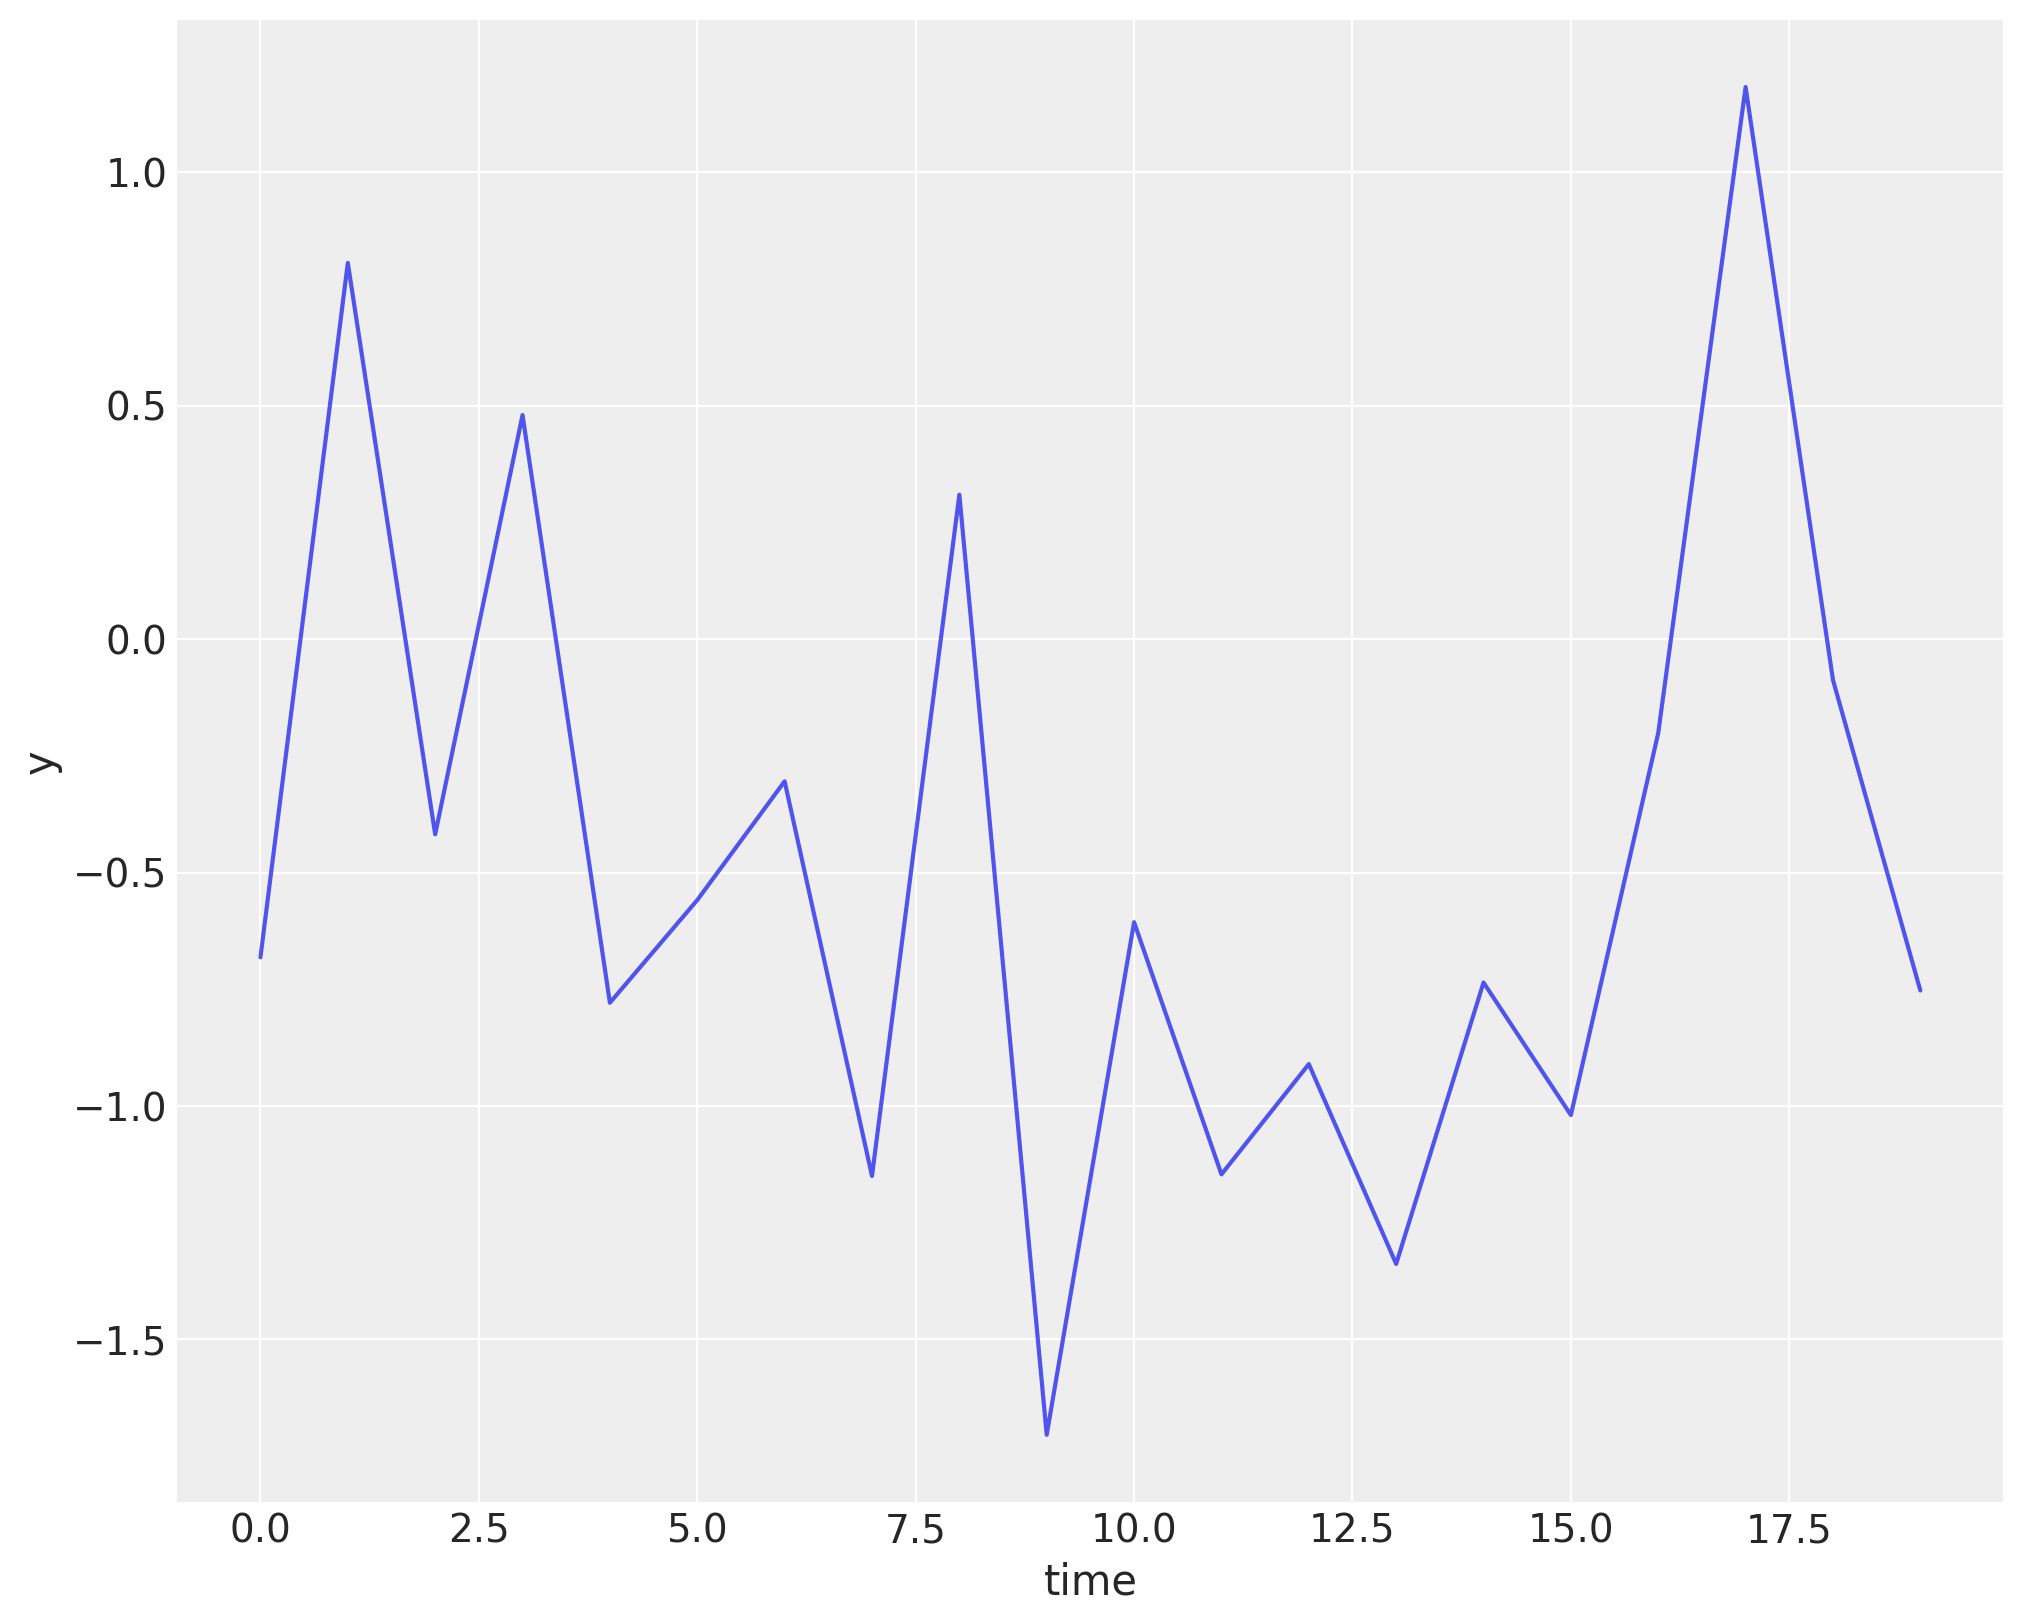

In [10]:
%config InlineBackend.figure_format = 'retina'
import arviz as az
az.style.use('arviz-darkgrid')

# plot time series 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(y, alpha=.8)
ax.set(xlabel='time', ylabel='y')
plt.show()

/Users/wang/Library/CloudStorage/GoogleDrive-thetheoryofeverythingcn@gmail.com/My Drive/23 Spring/TimeSeries/Project/Bayesian-inference/.venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 15 must be < 10.

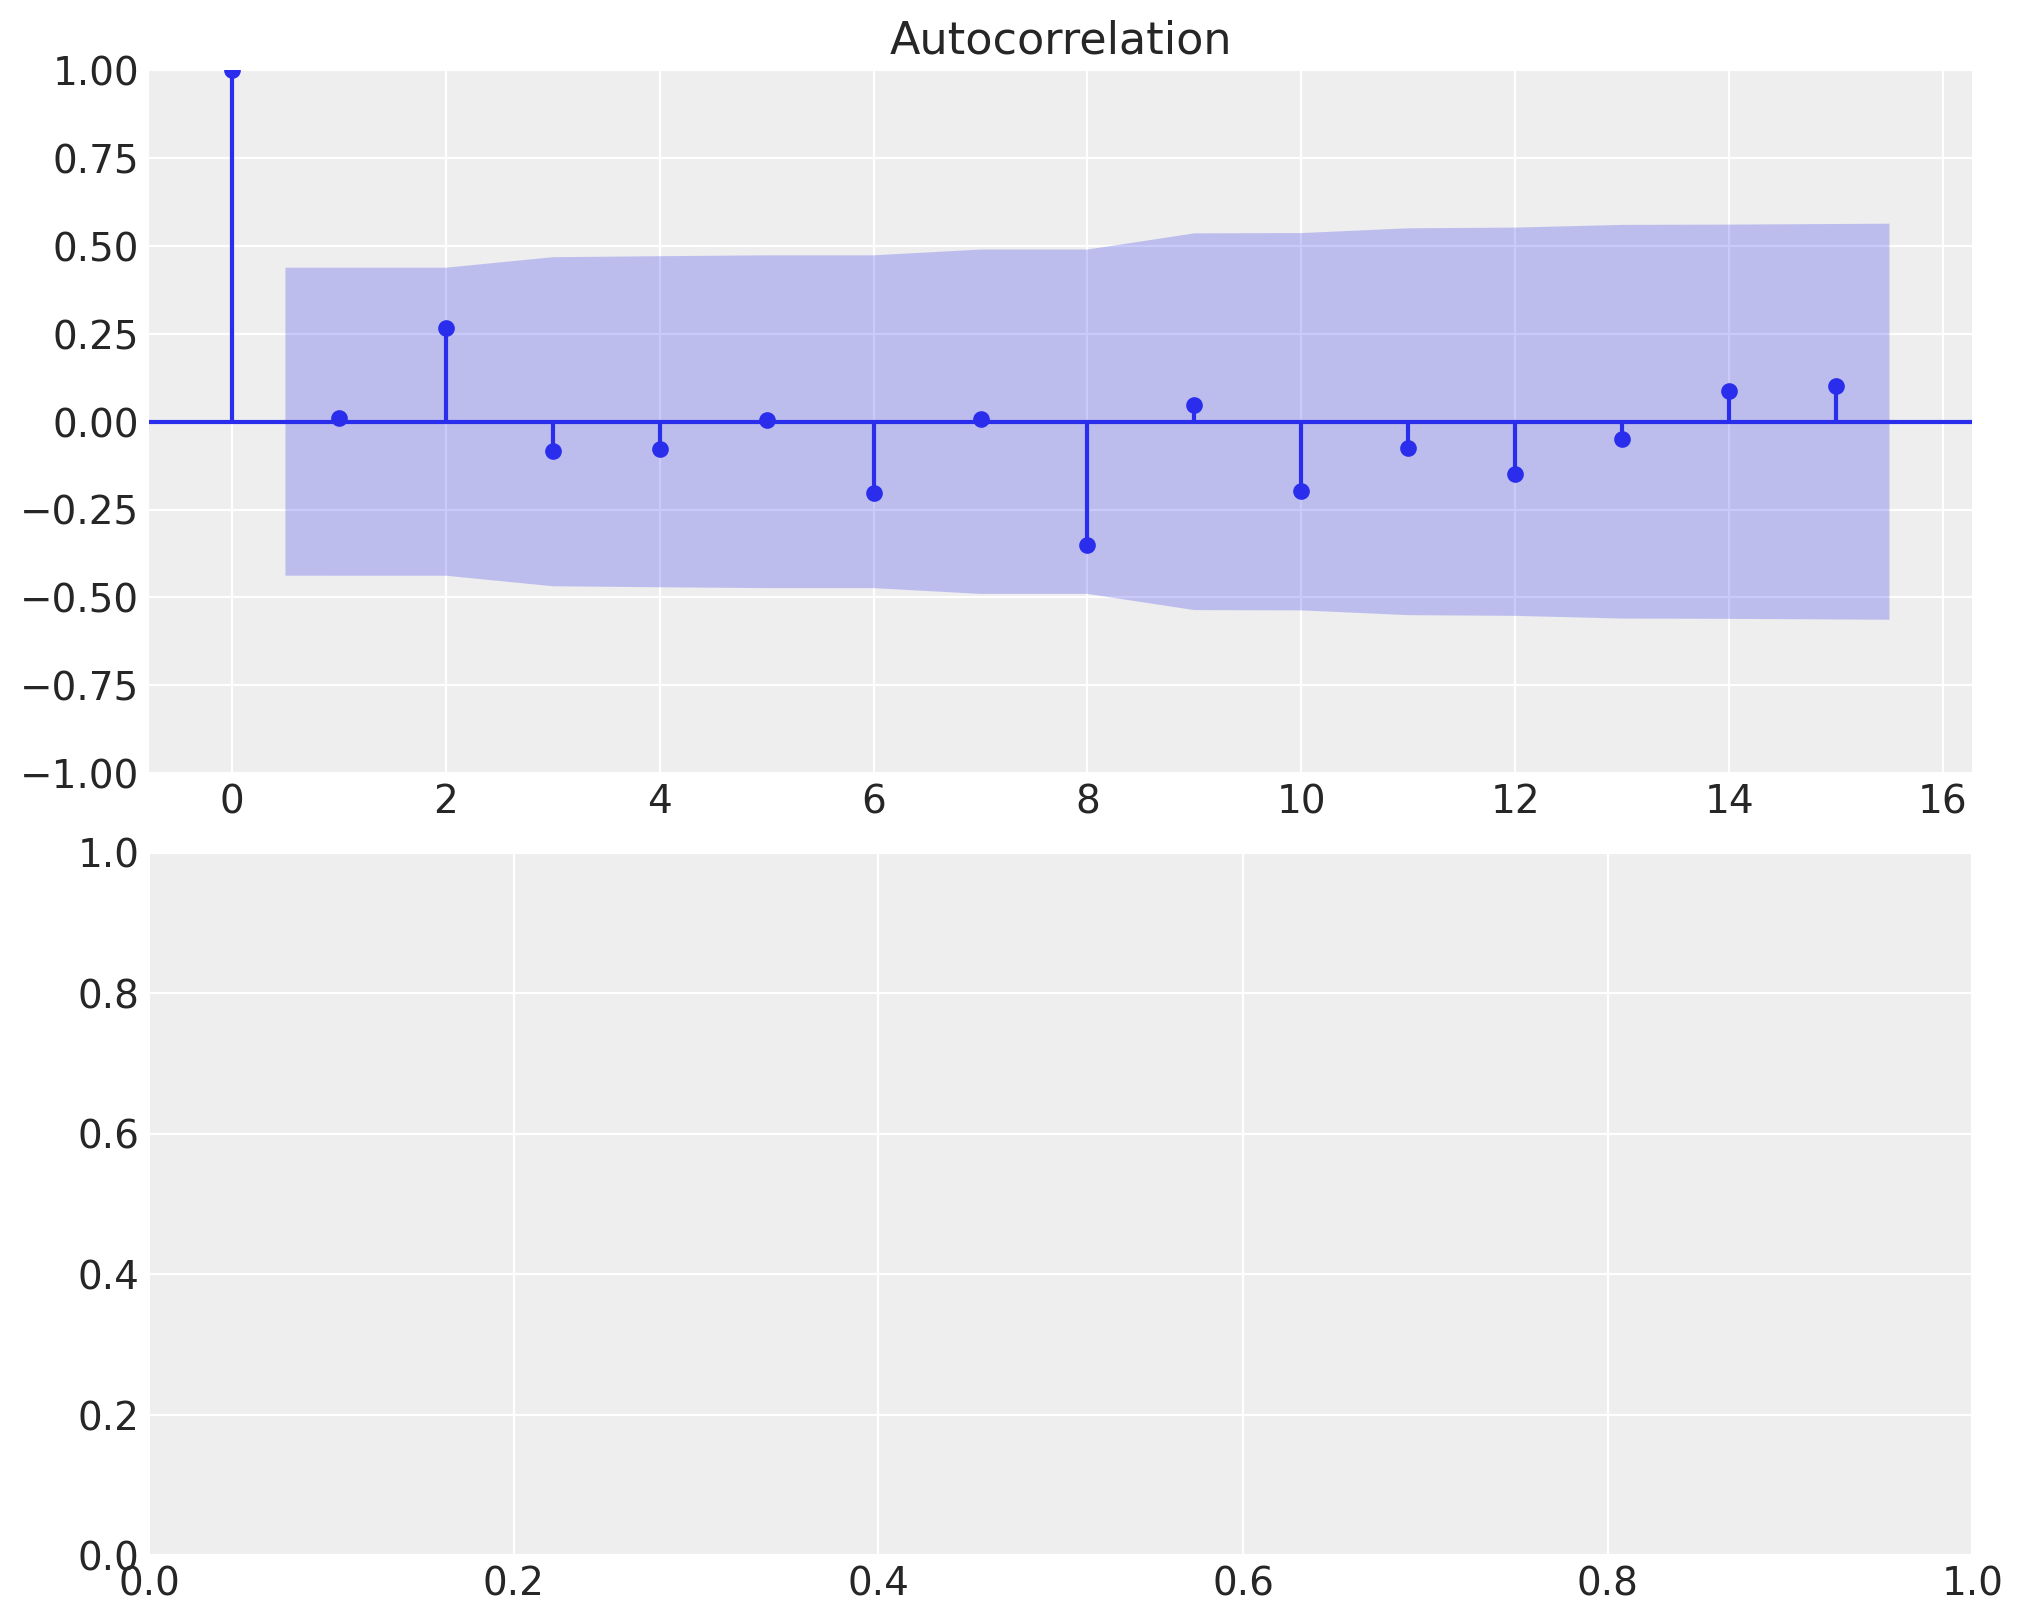

In [12]:
# plot acf and pacf 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8))
plot_acf(y, ax=ax1, lags=15)
plot_pacf(y, ax=ax2, lags=15)
plt.show()

In [13]:
# fit model
mod = sm.tsa.ARIMA(y, order=(2,0,2), trend='n')
res = mod.fit()

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   20
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 -21.958
Date:                Thu, 27 Apr 2023   AIC                             53.917
Time:                        11:31:50   BIC                             58.895
Sample:                             0   HQIC                            54.889
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2726      1.040      0.262      0.793      -1.766       2.312
ar.L2          0.4739      0.895      0.529      0.597      -1.281       2.229
ma.L1         -0.2046      1.283     -0.160      0.8

In [15]:
%load_ext autoreload
%autoreload 2

from arma_inference import run_MCMC_ARMApq

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
model = {'order': [2, 2], 'tab': {'params': [0,0,0,0], 'bse': [1,1,1,1]}}
trace = run_MCMC_ARMApq(y, 2000, model)

Sequential sampling (4 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [phi]
>>Metropolis: [theta]
>NUTS: [sigma]
CompoundStep
>CompoundStep
>>Metropolis: [phi]
>>Metropolis: [theta]
>NUTS: [sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.


           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
phi[0]   -0.030  1.076  -2.110    1.905      0.034    0.024    1033.0   
phi[1]    0.010  1.016  -1.854    1.947      0.030    0.021    1121.0   
theta[0] -0.014  0.987  -1.737    1.978      0.030    0.021    1111.0   
theta[1] -0.008  1.010  -1.852    1.951      0.030    0.021    1137.0   
sigma     0.000  0.000   0.000    0.000      0.000    0.000    3658.0   

          ess_tail  r_hat  
phi[0]      1496.0   1.01  
phi[1]      1489.0   1.00  
theta[0]    1589.0   1.00  
theta[1]    1323.0   1.00  
sigma       4703.0   1.00  


array([[<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

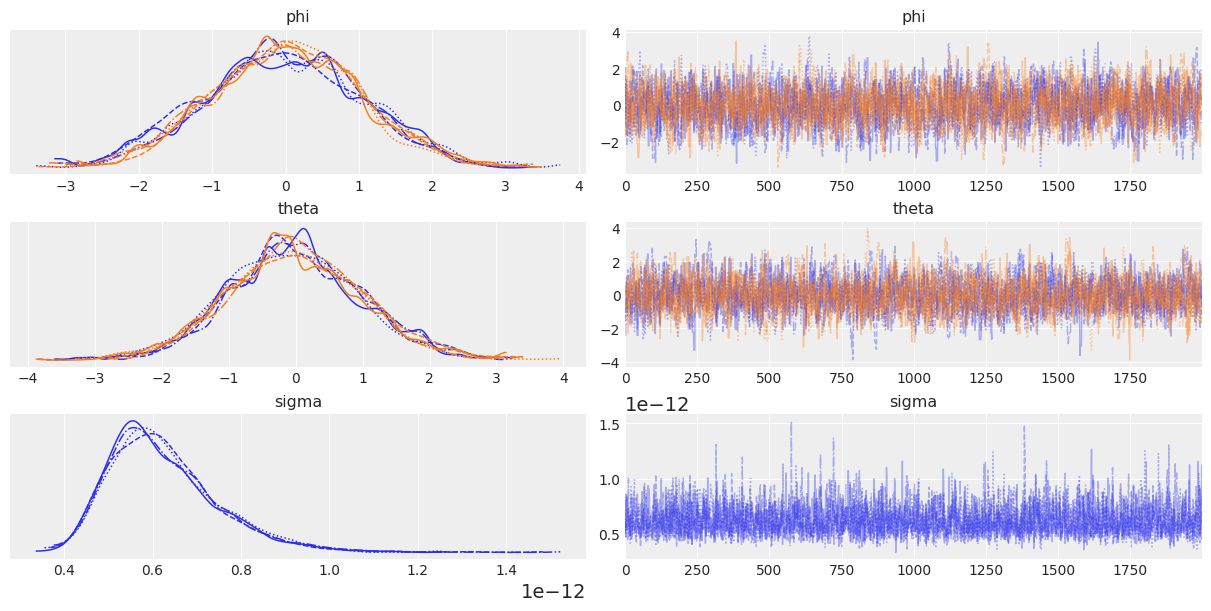

In [17]:
import arviz as az
az.style.use('arviz-darkgrid')
az.plot_trace(trace)

In [ ]:
mod.loglike(res.params)

-354.2258795419075

In [ ]:
import pytensor.tensor as tt

def logp(value: TensorVariable, params: TensorVariable):
    # extract parameters from tensors
    mod = sm.tsa.ARIMA(value.data, order=(2,0,2), trend='n')
    mod.fit()

    return tt.as_tensor(mod.loglikes(params.data))

NameError: name 'TensorVariable' is not defined

In [ ]:
with pm.Model() as bayesian_mod:
    phi_1 = pm.Normal('phi_1', mu=0, sigma=1)
    phi_2 = pm.Normal('phi_2', mu=0, sigma=1)
    theta_1 = pm.Normal('theta_1', mu=0, sigma=1)
    theta_2 = pm.Normal('theta_2', mu=0, sigma=1)
    sigma2 = pm.InverseGamma("sigma2", 2, 4)

    params = [phi_1, phi_2, theta_1, theta_2, sigma2]

    pm.CustomDist('likelihood', *params, logp, observed=y)

    trace = pm.sample(2000, tune=1000, cores=4)
    